SIGNATE
https://signate.jp/competitions/1376/submissions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# CSVファイルの指定
train_file_path = 'train.csv'
test_file_path = 'test.csv'

# CSVファイルを読込み
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# データフレームを辞書型に格納
dfs = {
    "学習データ": df_train,
    "テストデータ": df_test
}

# メイリオフォントの設定
plt.rcParams['font.family'] = 'Meiryo'


In [2]:
import numpy as np

# 0 を NaN に置き換えるカラムを指定
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 指定カラムの 0 を NaN に変換
df_train[columns_to_replace] = df_train[columns_to_replace].replace(0, np.nan)
df_test[columns_to_replace] = df_test[columns_to_replace].replace(0, np.nan)


In [3]:
def calculate_missing_data(df):
    # 各カラムの欠損値数を計算
    missing_values_count = df.isnull().sum()

    # 各カラムの欠損割合を計算
    missing_values_ratio = (missing_values_count / len(df)) * 100

    # 欠損値がある列のみを抽出
    missing_data = pd.DataFrame({
        'カラム名': missing_values_count.index,
        '欠損値数': missing_values_count.values,
        '欠損割合': missing_values_ratio.values
    })

    # 全体の欠損値数の合計を計算
    total_missing_count = missing_data['欠損値数'].sum()

    # 全体の欠損割合の合計を計算
    total_missing_ratio = missing_data['欠損割合'].mean()

    # 合計の行をデータフレームに追加
    total_row = pd.DataFrame({
        'カラム名': ['合計'],
        '欠損値数': [total_missing_count],
        '欠損割合': [total_missing_ratio]
    })

    # データフレームに合計の行を追加
    missing_data = pd.concat([missing_data, total_row], ignore_index=True)

    return missing_data

# 各データフレームに対して関数を適用
for key, df in dfs.items():
    missing_data = calculate_missing_data(df)
    print(f"\n「{key}」の欠損データ:")
    display(missing_data)


「学習データ」の欠損データ:


,カラム名,欠損値数,欠損割合
0,index,0,0.000000
1,Pregnancies,0,0.000000
2,Glucose,0,0.000000
3,BloodPressure,106,3.704998
4,SkinThickness,1680,58.720727
5,Insulin,2614,91.366655
6,BMI,0,0.000000
7,DiabetesPedigreeFunction,0,0.000000
8,Age,0,0.000000
9,Outcome,0,0.000000



「テストデータ」の欠損データ:


,カラム名,欠損値数,欠損割合
0,index,0,0.000000
1,Pregnancies,0,0.000000
2,Glucose,0,0.000000
3,BloodPressure,72,3.751954
4,SkinThickness,1104,57.529964
5,Insulin,1760,91.714435
6,BMI,0,0.000000
7,DiabetesPedigreeFunction,0,0.000000
8,Age,0,0.000000
9,合計,2936,16.999595


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# One-Hot Encoding の適用
def apply_one_hot_encoding(df):
    df_encoded = pd.get_dummies(df, drop_first=True)
    return df_encoded

# 量的変数の欠損値補完
def impute_missing_values_quantitative(df, column):
    if df[column].isna().sum() > 0:
        df_not_null = df[df[column].notnull()]
        df_null = df[df[column].isnull()]

        X = df_not_null.drop(columns=[column, 'index'])
        y = df_not_null[column]
        X_null = df_null.drop(columns=[column, 'index'])

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        df.loc[df[column].isnull(), column] = rf.predict(X_null)
    return df

# 質的変数の欠損値補完
def impute_missing_values_qualitative(df, column):
    if df[column].isna().sum() > 0:
        df_not_null = df[df[column].notnull()]
        df_null = df[df[column].isnull()]

        X = df_not_null.drop(columns=[column, 'id'])
        y = df_not_null[column]
        X_null = df_null.drop(columns=[column, 'id'])

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        df.loc[df[column].isnull(), column] = rf.predict(X_null)
    return df

# 量的変数と質的変数を識別
def identify_column_types(df):
    quantitative_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    qualitative_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # 'index' カラムを除外
    if 'index' in quantitative_columns:
        quantitative_columns.remove('index')
    if 'index' in qualitative_columns:
        qualitative_columns.remove('index')
    
    return quantitative_columns, qualitative_columns

# 量的変数と質的変数の欠損値を一括補完
def impute_missing_values(df):
    quantitative_columns, qualitative_columns = identify_column_types(df)
    
    for column in quantitative_columns:
        df = impute_missing_values_quantitative(df, column)
    
    for column in qualitative_columns:
        df = impute_missing_values_qualitative(df, column)
    
    return df

# 複数のデータフレームに欠損値補完を適用
def apply_impute_missing_values_to_dfs(dfs):
    for key, df in dfs.items():
        print(f"'{key}' に欠損値補完を適用します。")
        df_encoded = apply_one_hot_encoding(df)
        df_filled = impute_missing_values(df_encoded)
        dfs[key] = df_filled

# 各データフレームに欠損値補完を適用
apply_impute_missing_values_to_dfs(dfs)


'学習データ' に欠損値補完を適用します。
'テストデータ' に欠損値補完を適用します。


In [5]:
import pandas as pd
import numpy as np

def feature_engineering(df):
    # BMIと年齢の相互作用特徴量
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
    
    # カテゴリ変数の作成
    def categorize_glucose(glucose):
        if glucose < 80:
            return 'Low'
        elif 80 <= glucose < 100:
            return 'Normal'
        elif 100 <= glucose < 126:
            return 'Prediabetes'
        else:
            return 'High'
    df['Glucose_Category'] = df['Glucose'].apply(categorize_glucose).astype('category')
    
    def categorize_blood_pressure(bp):
        if bp < 60:
            return 'Low'
        elif 60 <= bp < 80:
            return 'Normal'
        else:
            return 'High'
    df['BloodPressure_Category'] = df['BloodPressure'].apply(categorize_blood_pressure).astype('category')
    
    df['Family_Risk'] = df['DiabetesPedigreeFunction'].apply(lambda x: 'High' if x >= 0.5 else 'Low').astype('category')
    
    def categorize_bmi(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif 18.5 <= bmi < 25:
            return 'Normal'
        elif 25 <= bmi < 30:
            return 'Overweight'
        else:
            return 'Obese'
    df['BMI_Category'] = df['BMI'].apply(categorize_bmi).astype('category')
    
    def categorize_age(age):
        if age < 30:
            return 'Young'
        elif 30 <= age < 50:
            return 'Middle'
        else:
            return 'Old'
    df['Age_Group'] = df['Age'].apply(categorize_age).astype('category')
    
    # インスリン-血糖比
    df['Insulin_Glucose_Ratio'] = df['Insulin'] / df['Glucose']
    df['Insulin_Glucose_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Glucose × Insulin 相互作用特徴量
    df['Glucose_Insulin_Interaction'] = df['Glucose'] * df['Insulin']
    
    # 血圧 × BMI 相互作用特徴量
    df['BloodPressure_BMI_Interaction'] = df['BloodPressure'] * df['BMI']
    
    # 高リスクフラグ
    df['High_Risk_Flag'] = ((df['BMI'] >= 30) & (df['Glucose'] >= 126) | (df['Age'] >= 50)).astype(int)
    
    # 健康スコア（スコアが高いほど健康）
    df['Health_Score'] = 1 / df['BMI'] + 1 / df['Glucose'] + 1 / df['BloodPressure']
    
    # 高リスク年齢フラグ
    df['High_Age_Risk'] = (df['Age'] >= 40).astype(int)
    
    # 妊娠回数リスクフラグ
    df['High_Pregnancies'] = (df['Pregnancies'] >= 6).astype(int)
    
    # One-Hot Encodingを適用
    df = pd.get_dummies(df, columns=['Glucose_Category', 'BloodPressure_Category', 'Family_Risk', 'BMI_Category', 'Age_Group'], drop_first=True)
    
    # 欠損値処理（数値変数は中央値で補完、カテゴリ変数は最頻値で補完）
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].median(), inplace=True)
    
    return df

# データフレームに新しい特徴を追加
for key in dfs:
    dfs[key] = feature_engineering(dfs[key])

# 学習データとテストデータのカラムを統一（Outcomeは学習データにのみ保持）
common_cols = list(set(dfs['学習データ'].columns) & set(dfs['テストデータ'].columns))

# 学習データには Outcome を強制的に含める
dfs['学習データ'] = dfs['学習データ'][common_cols + (['Outcome'] if 'Outcome' in dfs['学習データ'].columns else [])]

# テストデータには Outcome を含めない
dfs['テストデータ'] = dfs['テストデータ'][common_cols]

# 結果を表示
print("学習データのカラム一覧:", dfs['学習データ'].columns)
print("テストデータのカラム一覧:", dfs['テストデータ'].columns)
print(dfs['学習データ'].head())


学習データのカラム一覧: Index(['Glucose_Insulin_Interaction', 'BMI_Category_Overweight',
       'BloodPressure_BMI_Interaction', 'index', 'DiabetesPedigreeFunction',
       'Age_Group_Young', 'BMI_Age_Interaction', 'BMI',
       'Glucose_Category_Normal', 'BloodPressure', 'BMI_Category_Underweight',
       'High_Risk_Flag', 'BloodPressure_Category_Normal', 'Pregnancies',
       'Health_Score', 'Glucose_Category_Low', 'SkinThickness',
       'Family_Risk_Low', 'Glucose_Category_Prediabetes', 'Insulin',
       'Insulin_Glucose_Ratio', 'BloodPressure_Category_Low', 'Age_Group_Old',
       'Age', 'High_Age_Risk', 'Glucose', 'High_Pregnancies', 'Outcome'],
      dtype='object')
テストデータのカラム一覧: Index(['Glucose_Insulin_Interaction', 'BMI_Category_Overweight',
       'BloodPressure_BMI_Interaction', 'index', 'DiabetesPedigreeFunction',
       'Age_Group_Young', 'BMI_Age_Interaction', 'BMI',
       'Glucose_Category_Normal', 'BloodPressure', 'BMI_Category_Underweight',
       'High_Risk_Flag', 'BloodPressur

C:\Users\iriku\AppData\Local\Temp\ipykernel_16964\1200361559.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Insulin_Glucose_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\iriku\AppData\Local\Temp\ipykernel_16964\1200361559.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [6]:
def save_dfs_to_csv(dfs):
    for key, df in dfs.items():
        filename = f"processed_file/処理済み{key}.csv"
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"{filename} として保存しました。")

save_dfs_to_csv(dfs)


processed_file/処理済み学習データ.csv として保存しました。
processed_file/処理済みテストデータ.csv として保存しました。


In [7]:
# 各データフレームに対して関数を適用
for key, df in dfs.items():
    missing_data = calculate_missing_data(df)
    print(f"\n「{key}」の欠損データ:")
    display(missing_data)


「学習データ」の欠損データ:


,カラム名,欠損値数,欠損割合
0,Glucose_Insulin_Interaction,0,0.0
1,BMI_Category_Overweight,0,0.0
2,BloodPressure_BMI_Interaction,0,0.0
3,index,0,0.0
4,DiabetesPedigreeFunction,0,0.0
5,Age_Group_Young,0,0.0
6,BMI_Age_Interaction,0,0.0
7,BMI,0,0.0
8,Glucose_Category_Normal,0,0.0
9,BloodPressure,0,0.0



「テストデータ」の欠損データ:


,カラム名,欠損値数,欠損割合
0,Glucose_Insulin_Interaction,0,0.0
1,BMI_Category_Overweight,0,0.0
2,BloodPressure_BMI_Interaction,0,0.0
3,index,0,0.0
4,DiabetesPedigreeFunction,0,0.0
5,Age_Group_Young,0,0.0
6,BMI_Age_Interaction,0,0.0
7,BMI,0,0.0
8,Glucose_Category_Normal,0,0.0
9,BloodPressure,0,0.0


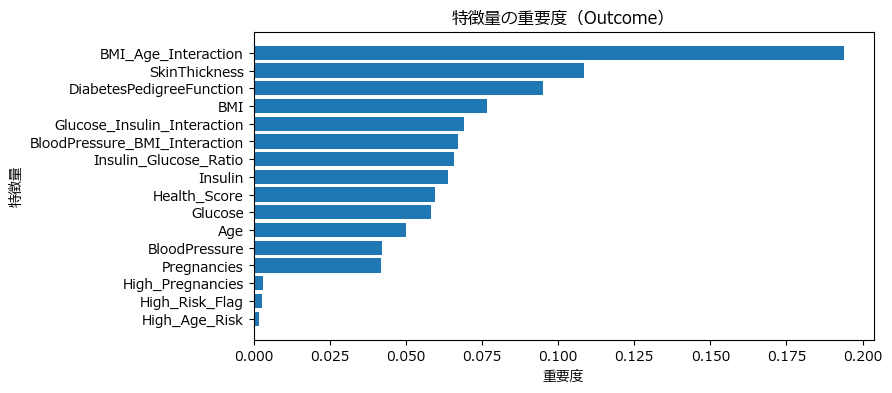

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def train_and_plot_feature_importance(df, target_column='Outcome', id_column='index'):
    # 特徴量とターゲットを分離
    features = df.drop(columns=[target_column, id_column])
    target = df[target_column]

    # カテゴリカルデータを数値に変換（必要に応じて）
    label_encoders = {}
    for column in features.select_dtypes(include='object').columns:
        label_encoders[column] = LabelEncoder()
        features[column] = label_encoders[column].fit_transform(features[column])

    # 数値データのみを特徴量として選択
    features = features.select_dtypes(include='number')

    # 欠損値の処理
    features = features.fillna(features.mean())

    # 訓練データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # ランダムフォレスト回帰モデルを訓練
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 特徴量の重要度を計算
    importances = model.feature_importances_
    feature_names = features.columns
    importance_df = pd.DataFrame({'特徴量': feature_names, '重要度': importances})
    importance_df = importance_df.sort_values(by='重要度', ascending=False)

    # 特徴量の重要度をプロット
    plt.figure(figsize=(8, 4))
    plt.barh(importance_df['特徴量'], importance_df['重要度'])
    plt.xlabel('重要度')
    plt.ylabel('特徴量')
    plt.title(f'特徴量の重要度（{target_column}）')
    plt.gca().invert_yaxis()
    plt.show()

    return model, importance_df

# 辞書型の学習データに対して、重要度の算出を適用
model, importance_df = train_and_plot_feature_importance(dfs['学習データ'], target_column='Outcome', id_column='index')


In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# データの前処理
def preprocess_data(df, target_column=None, id_column='index'):
    if target_column:
        features = df.drop(columns=[target_column, id_column])
        target = df[target_column]
    else:
        features = df.drop(columns=[id_column])
        target = None
    return features, target

# データの分割
def split_data(features, target, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# XGBoostを用いた学習
def train_xgboost(X_train, y_train):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

# モデルの評価
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"モデルの精度: {accuracy:.4f}")
    return accuracy

features, target = preprocess_data(dfs['学習データ'], target_column='Outcome')
X_train, X_test, y_train, y_test = split_data(features, target)
model = train_xgboost(X_train, y_train)
evaluate_model(model, X_test, y_test)
test_features, _ = preprocess_data(dfs['テストデータ'])
test_preds = model.predict(test_features)

output_df = pd.DataFrame({
    'id': dfs['テストデータ']['index'],
    'Predicted': test_preds
})

algorithm_name = "XGBoost"
output_filename = f"prediction_file/{algorithm_name}予測.csv"
output_df.to_csv(output_filename, index=False, header=False)
print(f"予測結果を '{output_filename}' に保存しました。")



モデルの精度: 0.8360
予測結果を 'prediction_file/XGBoost予測.csv' に保存しました。


c:\Users\iriku\venv\py311-gpu\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:14:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# 学習データとテストデータの取得（Outcomeは学習データにのみ含まれる前提）
df_train = dfs["学習データ"]
df_test = dfs["テストデータ"]

# ターゲットカラムとIDカラムの指定
target_column = 'Outcome'
id_column = 'index'

# 学習データから特徴量とターゲットを分離（IDカラムは除外）
X = df_train.drop(columns=[target_column, id_column])
y = df_train[target_column]

# テストデータはIDカラム以外が特徴量
X_test = df_test.drop(columns=[id_column])

# 学習データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoostClassifierの定義（パラメータは適宜調整してください）
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)

# モデルの学習（early_stopping_roundsを指定して過学習を防ぐ）
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

# 検証データで評価
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy)

# テストデータの予測
test_preds = model.predict(X_test)

# 予測結果をCSVに保存（IDと予測値の2列）
output_df = pd.DataFrame({
    'index': df_test[id_column],
    'Predicted': test_preds
})
output_filename = "prediction_file/CatBoost予測.csv"
output_df.to_csv(output_filename, index=False, header=False)
print(f"予測結果を '{output_filename}' に保存しました。")


0:	learn: 0.6432079	test: 0.6379422	best: 0.6379422 (0)	total: 141ms	remaining: 1m 10s
100:	learn: 0.2808396	test: 0.3862808	best: 0.3848700 (87)	total: 424ms	remaining: 1.67s
200:	learn: 0.1771534	test: 0.3731169	best: 0.3721265 (194)	total: 732ms	remaining: 1.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3721264858
bestIteration = 194

Shrink model to first 195 iterations.
Validation Accuracy: 0.8411867364746946
予測結果を 'prediction_file/CatBoost予測.csv' に保存しました。


In [11]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- データの準備 ---
# 事前処理済みのデータフレームを使用（dfs 辞書内の「学習データ」と「テストデータ」）
df_train = dfs["学習データ"]
df_test = dfs["テストデータ"]

# ターゲットカラムとIDカラムの指定
target_column = 'Outcome'
id_column = 'index'

# 学習データから特徴量とターゲットを分離（IDカラムは除外）
X = df_train.drop(columns=[target_column, id_column])
y = df_train[target_column]

# テストデータはIDカラム以外が特徴量
X_test = df_test.drop(columns=[id_column])

# 学習データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 各モデルの学習 ---
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# CatBoost
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=100)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

# --- 各モデルの予測確率取得 ---
# 検証データに対する予測確率（クラス1の確率）
xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
lgb_val_proba = lgb_model.predict_proba(X_val)[:, 1]
cat_val_proba = cat_model.predict_proba(X_val)[:, 1]

# テストデータに対する予測確率
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]
lgb_test_proba = lgb_model.predict_proba(X_test)[:, 1]
cat_test_proba = cat_model.predict_proba(X_test)[:, 1]

# --- アンサンブル予測（各モデルの予測確率の平均） ---
ensemble_val_proba = (xgb_val_proba + lgb_val_proba + cat_val_proba) / 3
ensemble_val_pred = (ensemble_val_proba >= 0.5).astype(int)
ensemble_val_accuracy = accuracy_score(y_val, ensemble_val_pred)
print("Ensemble Validation Accuracy:", ensemble_val_accuracy)

ensemble_test_proba = (xgb_test_proba + lgb_test_proba + cat_test_proba) / 3
ensemble_test_pred = (ensemble_test_proba >= 0.5).astype(int)

# --- 予測結果のCSV出力 ---
output_df = pd.DataFrame({
    id_column: df_test[id_column],
    'Predicted': ensemble_test_pred
})
output_filename = "prediction_file/Ensemble_XGB_LGBM_CatBoost予測.csv"
output_df.to_csv(output_filename, index=False, header=False)
print(f"予測結果を '{output_filename}' に保存しました。")


c:\Users\iriku\venv\py311-gpu\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 555, number of negative: 1733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 2288, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242570 -> initscore=-1.138641
[LightGBM] [Info] Start training from score -1.138641
0:	learn: 0.6432079	test: 0.6379422	best: 0.6379422 (0)	total: 4.32ms	remaining: 2.16s
100:	learn: 0.2808396	test: 0.3862808	best: 0.3848700 (87)	total: 313ms	remaining: 1.24s
200:	learn: 0.1771534	test: 0.3731169	best: 0.3721265 (194)	total: 625ms	remaining: 930ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3721264858
bestIteration = 194

Shrink model to first 195 iterations.
Ensemble Validation Accuracy: 0.837696335078534
予測結果を 'prediction_file/Ensemble_XGB_LGBM_CatBoost予測.csv' に

cuda
Epoch [100/100] Train Loss: 0.4625, Train Acc: 0.7915 | Val Loss: 0.4198, Val Acc: 0.7993


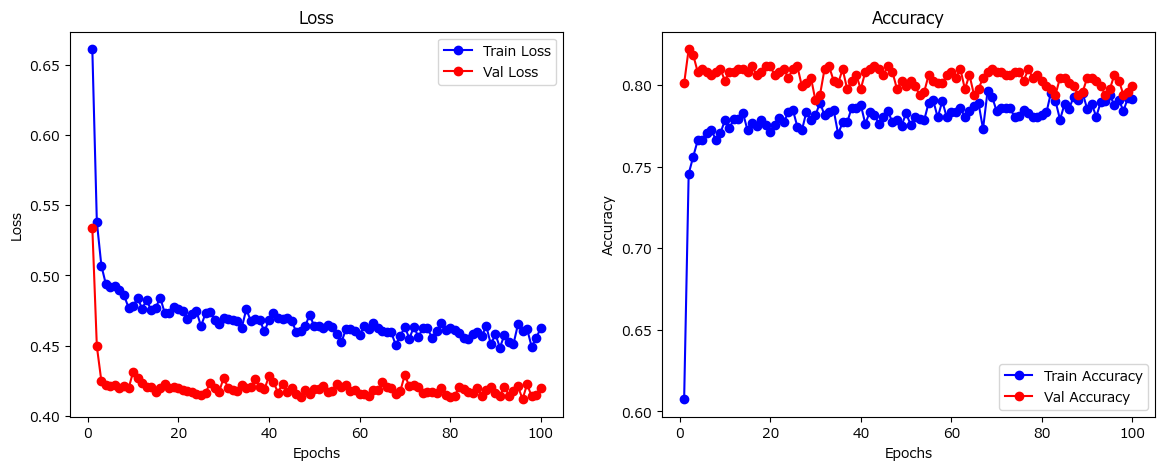

予測結果を 'prediction_file/DNN予測.csv' に保存しました。


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# データの前処理
def preprocess_data(df, target_column=None, id_column='index', scaler=None):
    if target_column:
        features = df.drop(columns=[target_column, id_column])
        target = df[target_column]
    else:
        features = df.drop(columns=[id_column])
        target = None

    # 標準化
    if scaler:
        features = scaler.fit_transform(features)

    # NumPy配列に変換
    features = np.array(features, dtype=np.float32)
    if target is not None:
        target = np.array(target, dtype=np.float32)
    
    return features, target

# データセットとデータローダの作成
def create_data_loaders(X_train, y_train, X_val, y_val, params):
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    return train_loader, val_loader

# DNNモデルの定義
class DNN(nn.Module):
    def __init__(self, input_size, layers):
        super(DNN, self).__init__()
        net_layers = []
        current_size = input_size
        
        # 指定されたレイヤー構成に従って全結合層とPReLUを追加
        for units, dropout_rate in layers:
            net_layers.append(nn.Linear(current_size, units))
            net_layers.append(nn.BatchNorm1d(units))
            net_layers.append(nn.PReLU())
            if dropout_rate > 0:
                net_layers.append(nn.Dropout(dropout_rate))
            current_size = units
        
        # 最終層を追加（シグモイド関数で出力を0~1にスケーリング）
        net_layers.append(nn.Linear(current_size, 1))
        net_layers.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*net_layers)
    
    def forward(self, x):
        return self.layers(x)

# モデルの訓練と評価
def train_model(model, train_loader, val_loader, criterion, optimizer, params):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    num_epochs = params['num_epochs']
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        correct_train_predictions = 0
        correct_val_predictions = 0
        total_train_samples = 0
        total_val_samples = 0

        # 訓練データでの訓練
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).view(-1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = (outputs >= 0.5).float()  # 0.5を閾値にしてクラス分類
            correct_train_predictions += (preds == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        # 検証データでの評価
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).view(-1)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
                preds = (outputs >= 0.5).float()
                correct_val_predictions += (preds == y_batch).sum().item()
                total_val_samples += y_batch.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # プログレスバーの表示
        print(f"\rEpoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}", end="")

    # 最後に改行を追加して、次の出力が正しい位置に表示されるようにする
    print()

    return train_losses, val_losses, train_accuracies, val_accuracies

# モデルの予測
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test).to(device)
        predictions = model(X_test).view(-1).cpu().numpy()
        predictions = (predictions >= 0.5).astype(int)  # 0.5を閾値として分類
    return predictions

# 訓練結果をプロットする関数
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Lossのプロット
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 各種パラメータを辞書で定義
params = {
    'batch_size': 8,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'layers': [
        (64, 0.5),
        # (64, 0.5),
        # (128, 0.5),
        # (256, 0.5),
        # (512, 0.5),
        # (1024, 0.5),
        # (2048, 0.5),
    ],
    'scaler': StandardScaler()
}

# 学習データを用いて実行
key = '学習データ'
test_key = 'テストデータ'

# 学習データの前処理
features, target = preprocess_data(dfs['学習データ'], target_column='Outcome', scaler=params['scaler'])

# データ分割
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# データローダの作成
train_loader, val_loader = create_data_loaders(X_train, y_train, X_val, y_val, params)

# モデルの初期化
model = DNN(input_size=X_train.shape[1], layers=params['layers']).to(device)
criterion = nn.BCELoss()  # バイナリクロスエントロピー
optimizer = optim.RAdam(model.parameters(), lr=params['learning_rate'])

# モデルの訓練
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, params)

# 訓練結果のプロット
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

# テストデータの前処理
test_features, _ = preprocess_data(dfs['テストデータ'], scaler=params['scaler'])

# テストデータを用いて予測
test_preds = predict(model, test_features)

# idと予測結果をCSVに保存
algorithm_name = 'DNN'
output_filename = f'prediction_file/{algorithm_name}予測.csv'
output_df = pd.DataFrame({
    'index': dfs['テストデータ']['index'],
    'Predicted': test_preds
})
output_df.to_csv(output_filename, index=False, header=False)
print(f"予測結果を '{output_filename}' に保存しました。")